# Import of Librerie

In [1]:
import zipfile
import os

from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import shutil
import cv2

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import copy
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.transforms import ToPILImage

# Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

In [3]:
# Define the path to your zip file
file_path = '/content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/hand_craft_dataset/only_landmarks.zip'  # Replace 'your_file.zip' with your file's name

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data')

In [4]:
# Percorso della directory in cui salvare le immagini
output_path = '/content/sample_data/only_landmarks/nothing'

# Assicurati che la directory esista
os.makedirs(output_path, exist_ok=True)

# Dimensioni delle immagini
width, height = 640, 480

# Numero di immagini da creare
num_images = 600  # Puoi modificare questo numero in base alle tue esigenze

# Crea e salva le immagini
for i in range(num_images):
    # Crea un'immagine bianca
    white_image = np.ones((height, width, 3), dtype=np.uint8) * 255

    # Percorso dell'immagine di output
    image_path = os.path.join(output_path, f'white_image_{i+1}.png')

    # Salva l'immagine
    cv2.imwrite(image_path, white_image)

print(f"Created {num_images} white images in '{output_path}'")


Created 600 white images in '/content/sample_data/only_landmarks/nothing'


In [ ]:
# Definisci il percorso della cartella principale
path = '/content/sample_data/landmarks'

# Elenca tutte le cartelle nella directory principale
folders = os.listdir(path)

# Itera attraverso ogni cartella
for folder in folders:
    # Controlla se il nome della cartella contiene '_label'
    if '_label' in folder:
        # Crea il nuovo nome della cartella rimuovendo '_label'
        new_name = folder.replace('_label', '')

        # Definisci il percorso completo della cartella corrente e della nuova cartella
        old_folder_path = os.path.join(path, folder)
        new_folder_path = os.path.join(path, new_name)

        # Rinomina la cartella
        os.rename(old_folder_path, new_folder_path)
        print(f"Rinominata '{old_folder_path}' in '{new_folder_path}'")

print("Rinominazione completata!")



FileNotFoundError: [Errno 2] No such file or directory: '/content/sample_data/landmarks'

# Data Mangement

In [ ]:
def has_bounding_box(image_path, bbox_color=(23, 245, 21)):
    # Legge l'immagine
    image = cv2.imread(image_path)
    if image is None:
        return False

    # Converti l'immagine in formato RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Crea una maschera per il colore specifico della bounding box
    lower_bound = np.array(bbox_color) - 10
    upper_bound = np.array(bbox_color) + 10
    mask = cv2.inRange(image_rgb, lower_bound, upper_bound)

    # Trova i contorni della maschera
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
        if len(approx) == 4:  # Verifica se il contorno è rettangolare
            return True
    return False

def count_images_without_bbox(root_path, bbox_color=(23, 245, 21)):
    count_without_bbox = 0

    # Sotto-cartelle delle lettere
    sub_dirs = [
        'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
        'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
        'del', 'nothing', 'space'
    ]

    for sub_dir in sub_dirs:
        dir_path = os.path.join(root_path, sub_dir)
        if not os.path.exists(dir_path):
            continue
        for image_name in os.listdir(dir_path):
            image_path = os.path.join(dir_path, image_name)
            if not has_bounding_box(image_path, bbox_color):
                count_without_bbox += 1

    return count_without_bbox

# Percorso della cartella radice
root_path = '/content/sample_data/landmarks'

# Conta delle immagini senza bounding box
count = count_images_without_bbox(root_path)

# Stampa del risultato
print(f"Numero di immagini senza bounding box: {count}")


Numero di immagini senza bounding box: 1718


In [ ]:
import shutil
from pathlib import Path

# Percorso della directory da svuotare
directory_to_clear = Path('/content/sample_data/DATA')

# Funzione per eliminare tutto il contenuto della directory
def clear_directory(directory_path):
    if directory_path.exists() and directory_path.is_dir():
        shutil.rmtree(directory_path)
        print(f"Tutto il contenuto di {directory_path} è stato eliminato.")
        # Ricrea la directory dopo averla eliminata
        directory_path.mkdir(parents=True, exist_ok=True)
    else:
        print(f"La directory {directory_path} non esiste o non è una directory valida.")

# Esegui la funzione per svuotare la directory
#clear_directory(directory_to_clear)


Tutto il contenuto di /content/sample_data/DATA è stato eliminato.


# Check dimension

In [ ]:
def check_image_dimensions(directory):
    dimensions = None
    all_same = True

    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('jpg', 'png')):
                image_path = os.path.join(root, file)
                with Image.open(image_path) as img:
                    current_dimensions = img.size

                    if dimensions is None:
                        dimensions = current_dimensions
                    elif current_dimensions != dimensions:
                        print(f"Dimension mismatch found in file: {image_path} (Dimensions: {current_dimensions})")
                        all_same = False

    if all_same:
        print("All images have the same dimensions:", dimensions)
    else:
        print("Not all images have the same dimensions.")

# Path to the directory containing the images
directory_path = "/content/sample_data/only_landmarks"

# Check if all images have the same dimensions
check_image_dimensions(directory_path)

All images have the same dimensions: (640, 480)


# Code for trainloader validation loader e trainloader



In [5]:
def create_folders(base_path, categories):
    for category in categories:
        os.makedirs(os.path.join(base_path, category), exist_ok=True)

def count_images_in_subfolders(base_path, categories):
    counts = {}
    for category in categories:
        category_path = os.path.join(base_path, category)
        if os.path.isdir(category_path):
            counts[category] = len(os.listdir(category_path))
    return counts

def print_image_counts(counts, folder_name):
    print(f"Image counts in {folder_name} folder:")
    for category, count in counts.items():
        print(f"{category}: {count}")
    print()

def split_dataset(dataset_path, train_path, val_path, test_path, split_ratio=(0.9, 0.05, 0.05)):
    categories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

    create_folders(train_path, categories)
    create_folders(val_path, categories)
    create_folders(test_path, categories)

    original_counts = count_images_in_subfolders(dataset_path, categories)
    print_image_counts(original_counts, 'original dataset')

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        images = os.listdir(category_path)

        random.shuffle(images)

        train_end = int(len(images) * split_ratio[0])
        val_end = train_end + int(len(images) * split_ratio[1])

        train_images = images[:train_end]
        val_images = images[train_end:val_end]
        test_images = images[val_end:]

        for image in train_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(train_path, category, image))
        for image in val_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(val_path, category, image))
        for image in test_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(test_path, category, image))

    train_counts = count_images_in_subfolders(train_path, categories)
    val_counts = count_images_in_subfolders(val_path, categories)
    test_counts = count_images_in_subfolders(test_path, categories)

    print_image_counts(train_counts, 'train')
    print_image_counts(val_counts, 'validation')
    print_image_counts(test_counts, 'test')

if __name__ == "__main__":
    dataset_path = '/content/sample_data/only_landmarks'
    train_path = '/content/sample_data/DATA/train'
    val_path = '/content/sample_data/DATA/validation'
    test_path = '/content/sample_data/DATA/test'

    split_dataset(dataset_path, train_path, val_path, test_path)


Image counts in original dataset folder:
I: 601
L: 601
O: 601
Z: 601
A: 600
G: 601
nothing: 600
U: 601
W: 601
K: 601
P: 601
J: 601
S: 602
del: 590
D: 601
T: 601
M: 601
N: 601
E: 601
B: 601
R: 601
H: 601
F: 601
Y: 601
X: 601
V: 601
C: 601
space: 601
Q: 601

Image counts in train folder:
I: 540
L: 540
O: 540
Z: 540
A: 540
G: 540
nothing: 540
U: 540
W: 540
K: 540
P: 540
J: 540
S: 541
del: 531
D: 540
T: 540
M: 540
N: 540
E: 540
B: 540
R: 540
H: 540
F: 540
Y: 540
X: 540
V: 540
C: 540
space: 540
Q: 540

Image counts in validation folder:
I: 30
L: 30
O: 30
Z: 30
A: 30
G: 30
nothing: 30
U: 30
W: 30
K: 30
P: 30
J: 30
S: 30
del: 29
D: 30
T: 30
M: 30
N: 30
E: 30
B: 30
R: 30
H: 30
F: 30
Y: 30
X: 30
V: 30
C: 30
space: 30
Q: 30

Image counts in test folder:
I: 31
L: 31
O: 31
Z: 31
A: 30
G: 31
nothing: 30
U: 31
W: 31
K: 31
P: 31
J: 31
S: 31
del: 30
D: 31
T: 31
M: 31
N: 31
E: 31
B: 31
R: 31
H: 31
F: 31
Y: 31
X: 31
V: 31
C: 31
space: 31
Q: 31



In [6]:
transform_train = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.ToTensor(),
])

In [7]:
# Percorsi delle directory
train_path = '/content/sample_data/DATA/train'
val_path = '/content/sample_data/DATA/validation'
test_path = '/content/sample_data/DATA/test'

# Caricamento dei dataset
train_data = ImageFolder(root=train_path, transform=transform_train)
val_data = ImageFolder(root=val_path, transform=transform_test)
test_data = ImageFolder(root=test_path, transform=transform_test)

# Dimensione del batch
batch_size = 16

# Creazione dei DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

class_names = train_data.classes
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


# SwinTransformer
image size 640x480

In [8]:
import torch
import torch.nn as nn
from torchvision import models

# Definisci il modello SwinTransformer pre-addestrato
class HandGestureSwinTransformer(nn.Module):
    def __init__(self, num_classes=29):
        super(HandGestureSwinTransformer, self).__init__()
        # Carica il modello SwinTransformer pre-addestrato
        self.swin_transformer = models.swin_t(weights='IMAGENET1K_V1')

        # Sostituisci l'ultimo layer completamente connesso
        num_ftrs = self.swin_transformer.head.in_features
        self.swin_transformer.head = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.swin_transformer(x)

# Crea un'istanza del modello
num_classes = 29  # Numero di classi per il task di ASL hand gesture detection
model = HandGestureSwinTransformer(num_classes=num_classes)

# Stampa del modello per verificare la struttura
print(model)


Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 130MB/s]


HandGestureSwinTransformer(
  (swin_transformer): SwinTransformer(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): Permute()
        (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      )
      (1): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): ShiftedWindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (proj): Linear(in_features=96, out_features=96, bias=True)
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (0): Linear(in_features=96, out_features=384, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=384, out_features=96, bias=True)
            (

In [9]:
# Definizione della funzione di perdita e dell'ottimizzatore
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

HandGestureSwinTransformer(
  (swin_transformer): SwinTransformer(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): Permute()
        (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      )
      (1): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): ShiftedWindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (proj): Linear(in_features=96, out_features=96, bias=True)
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (0): Linear(in_features=96, out_features=384, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=384, out_features=96, bias=True)
            (

# Train

In [10]:
# Liste per tracciare le metriche
train_losses = []
val_losses = []
val_accuracies = []

# Definizione del loop di addestramento e validazione
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Ogni epoca ha una fase di addestramento e una di validazione
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Impostare il modello in modalità training
                dataloader = train_loader
            else:
                model.eval()  # Impostare il modello in modalità evaluation
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterare sui dati con tqdm per visualizzare la barra di progresso
            for inputs, labels in tqdm(dataloader, desc=f'{phase} Epoch {epoch}/{num_epochs - 1}', leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Resettare i gradienti dell'ottimizzatore
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + ottimizzazione solo nella fase di addestramento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Salvare le metriche
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

                # Copiare il modello se ha migliorato la accuratezza su validation
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Acc: {best_acc:.4f}')

    # Caricare i pesi migliori del modello
    model.load_state_dict(best_model_wts)
    return model

# Esegui l'addestramento del modello
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

# Percorso di salvataggio
save_path = '/content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/hand_craft_dataset/SwinTransformer_only_landmark_hand_gesture_cnn_with_metrics.pth'

# Salvare il modello e le metriche
torch.save({
    'model_state_dict': model.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
}, save_path)

print(f"Modello e metriche salvate con successo in {save_path}.")

Epoch 0/4
----------


train Loss: 3.2292 Acc: 0.1183


val Loss: 2.8294 Acc: 0.2681
Epoch 1/4
----------


train Loss: 1.7468 Acc: 0.6072


val Loss: 1.7252 Acc: 0.4407
Epoch 2/4
----------


train Loss: 0.7436 Acc: 0.8748


val Loss: 1.6745 Acc: 0.5616
Epoch 3/4
----------


train Loss: 0.4116 Acc: 0.9393


val Loss: 2.4081 Acc: 0.4396
Epoch 4/4
----------


train Loss: 0.2641 Acc: 0.9672


val Loss: 2.1840 Acc: 0.5132
Best val Acc: 0.5616
Modello e metriche salvate con successo in /content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/hand_craft_dataset/SwinTransformer_only_landmark_hand_gesture_cnn_with_metrics.pth.


# continue training

In [ ]:
import torch
import copy
from tqdm import tqdm

# Percorso di caricamento
load_path = '/content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/hand_craft_dataset/2_VGG16_only_landmark_hand_gesture_cnn_with_metrics.pth'

# Caricare il modello e le metriche salvate
checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint['model_state_dict'])
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']
val_accuracies = checkpoint['val_accuracies']

# Continuare l'addestramento del modello
def continue_train_model(model, train_loader, val_loader, criterion, optimizer, start_epoch, num_epochs=4):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = max(val_accuracies)  # Inizializzare con la migliore accuratezza salvata

    for epoch in range(start_epoch, start_epoch + num_epochs):
        print(f'Epoch {epoch}/{start_epoch + num_epochs - 1}')
        print('-' * 10)

        # Ogni epoca ha una fase di addestramento e una di validazione
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Impostare il modello in modalità training
                dataloader = train_loader
            else:
                model.eval()  # Impostare il modello in modalità evaluation
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterare sui dati con tqdm per visualizzare la barra di progresso
            for inputs, labels in tqdm(dataloader, desc=f'{phase} Epoch {epoch}/{start_epoch + num_epochs - 1}', leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Resettare i gradienti dell'ottimizzatore
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + ottimizzazione solo nella fase di addestramento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Salvare le metriche
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

                # Copiare il modello se ha migliorato la accuratezza su validation
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Acc: {best_acc:.4f}')

    # Caricare i pesi migliori del modello
    model.load_state_dict(best_model_wts)
    return model

# Continuare l'addestramento del modello
model = continue_train_model(model, train_loader, val_loader, criterion, optimizer, start_epoch=12, num_epochs=5)

# Salvare nuovamente il modello e le metriche
torch.save({
    'model_state_dict': model.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
}, load_path)

print(f"Modello e metriche aggiornate salvate con successo in {load_path}.")


KeyboardInterrupt: 

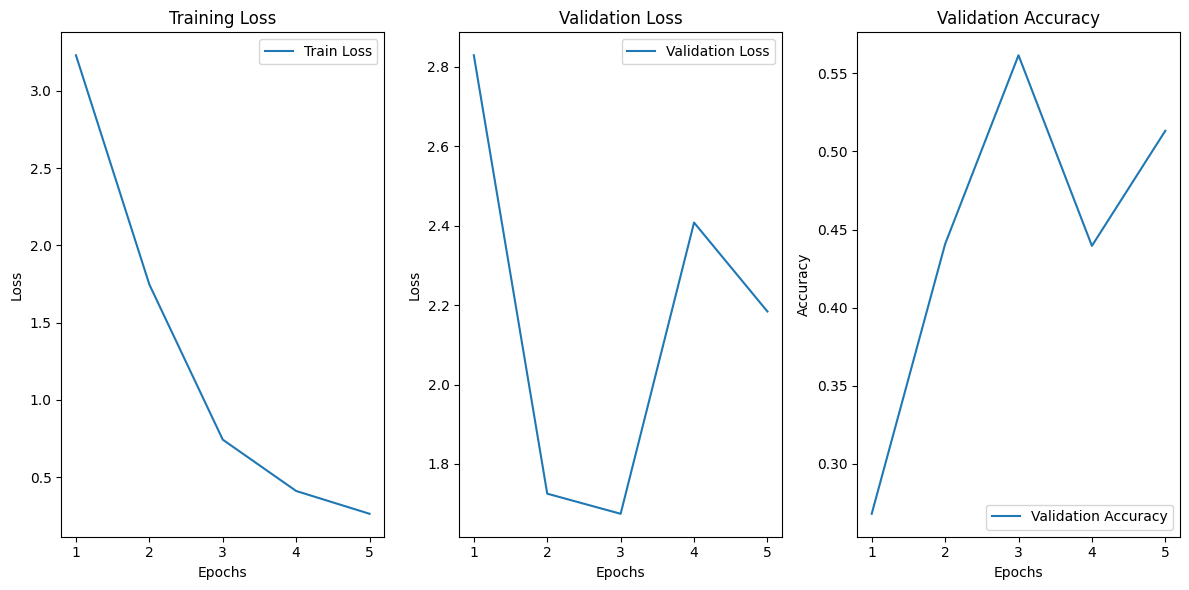

In [11]:
# Percorso del file salvato
file_path = '/content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/hand_craft_dataset/SwinTransformer_only_landmark_hand_gesture_cnn_with_metrics.pth'

# Caricamento del file con mappatura su CPU
checkpoint = torch.load(file_path, map_location=torch.device('cpu'))

# Recupero delle metriche
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']
val_accuracies = checkpoint['val_accuracies']

# Conversione dei tensori in numpy arrays se necessario
if isinstance(val_accuracies[0], torch.Tensor):
    val_accuracies = [acc.cpu().numpy() for acc in val_accuracies]

# Plot delle metriche
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))

# Plot del training loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot del validation loss
plt.subplot(1, 3, 2)
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

# Plot della validation accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Test of CNN

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

Accuracy: 0.5446
Precision: 0.5903
Recall: 0.5446
F1 Score: 0.5034
Classification Report:
              precision    recall  f1-score   support

           A       0.59      0.90      0.71        30
           B       0.15      1.00      0.27        31
           C       0.89      1.00      0.94        31
           D       0.71      0.39      0.50        31
           E       0.59      0.74      0.66        31
           F       1.00      0.71      0.83        31
           G       0.00      0.00      0.00        31
           H       1.00      0.29      0.45        31
           I       0.00      0.00      0.00        31
           J       1.00      0.03      0.06        31
           K       0.00      0.00      0.00        31
           L       1.00      0.84      0.91        31
           M       0.00      0.00      0.00        31
           N       0.00      0.00      0.00        31
           O       0.97      1.00      0.98        31
           P       0.00      0.00      0.00  

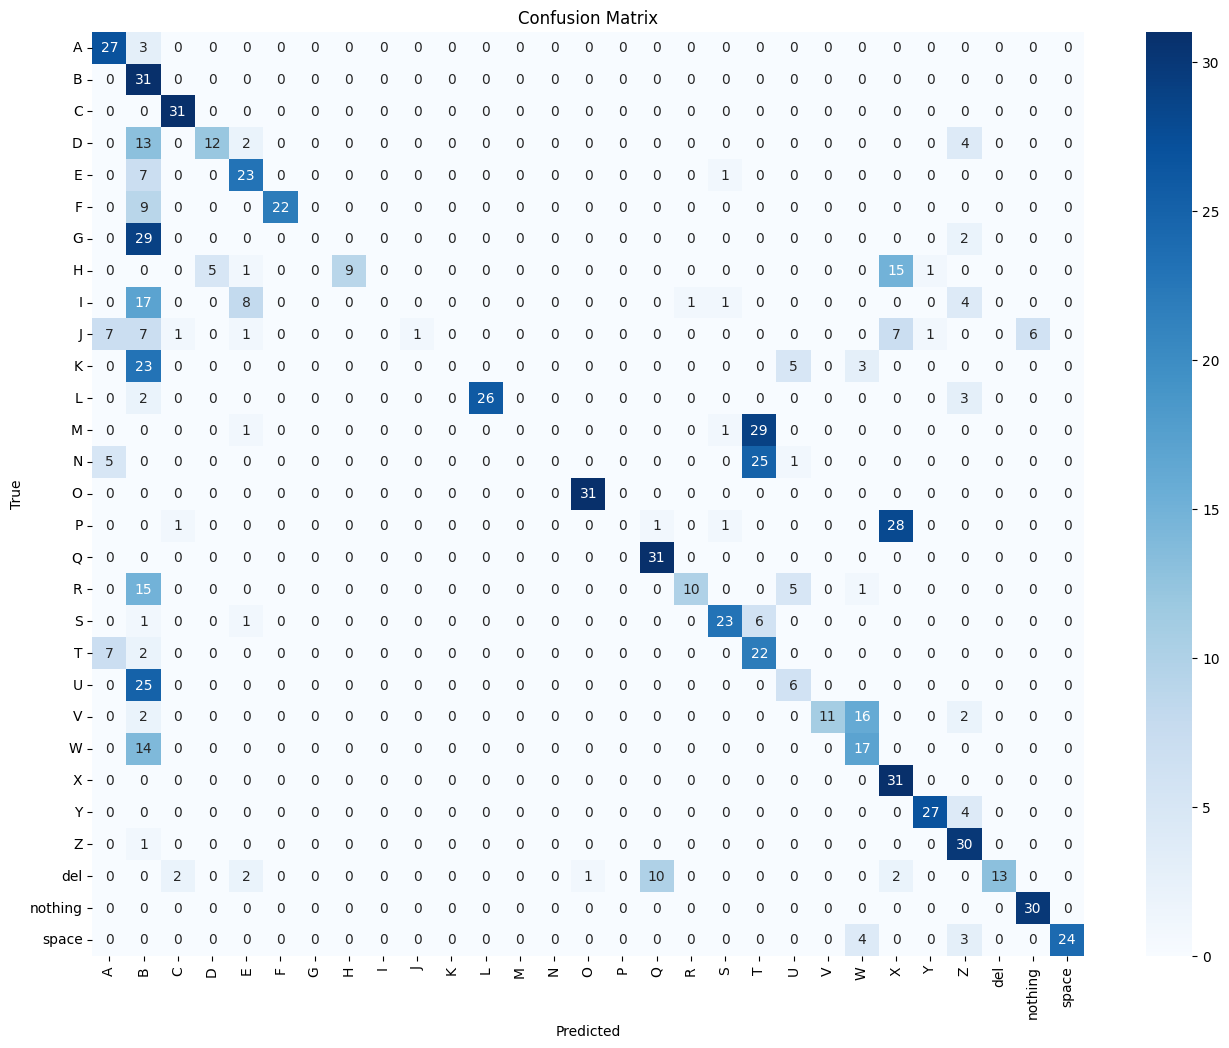

In [12]:
# Percorso del file salvato
file_path = '/content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/hand_craft_dataset/SwinTransformer_only_landmark_hand_gesture_cnn_with_metrics.pth'
# Caricamento del modello
num_classes = len(test_data.classes)
model = HandGestureSwinTransformer(num_classes=num_classes)

checkpoint = torch.load(file_path)
model.load_state_dict(checkpoint['model_state_dict'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Funzione per il calcolo delle metriche
def calculate_metrics(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=test_data.classes)

    accuracy = np.sum(all_preds == all_labels) / len(all_labels)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('Classification Report:')
    print(class_report)

    plt.figure(figsize=(16, 12))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.classes, yticklabels=test_data.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Esegui il calcolo delle metriche
calculate_metrics(model, test_loader)

In [ ]:
# Percorso del file salvato
file_path = '/content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/hand_craft_dataset/VGG16_only_landmark_hand_gesture_cnn_with_metrics.pth'
checkpoint = torch.load(file_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Funzione per il calcolo delle metriche
def calculate_metrics(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Calculating metrics', leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=test_data.classes)

    accuracy = np.sum(all_preds == all_labels) / len(all_labels)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('Classification Report:')
    print(class_report)

    plt.figure(figsize=(16, 12))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.classes, yticklabels=test_data.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return all_preds, all_labels

# Funzione per visualizzare le prime 50 immagini con le etichette predette
def plot_predictions(model, test_loader, labels, max_images=50):
    model.eval()
    images_displayed = 0
    fig, axs = plt.subplots(10, 5, figsize=(20, 40))
    axs = axs.flatten()

    with torch.no_grad():
        for inputs, _ in test_loader:
            if images_displayed >= max_images:
                break
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                if images_displayed >= max_images:
                    break
                img = inputs[i].cpu().permute(1, 2, 0).numpy()
                img = (img * 255).astype(np.uint8)
                axs[images_displayed].imshow(img)
                axs[images_displayed].set_title(f'Predicted: {labels[preds[i].item()]}')
                axs[images_displayed].axis('off')
                images_displayed += 1

    plt.show()

# Esegui il calcolo delle metriche
all_preds, all_labels = calculate_metrics(model, test_loader)

# Fai predizioni e visualizza i risultati
labels = [
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
    'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    'del', 'nothing', 'space'
]
plot_predictions(model, test_loader, labels, max_images=50)

KeyboardInterrupt: 